### GP Fitting
Author: Allen Ross  
Date: 5/18/21  

In [33]:
## Setup
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary, set_trainable

In [16]:
# Prediction function
def gp_predict_fun(gp, xmin, xmax, X, idx):
    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)
    
    # Create test points
    x_new = np.zeros_like(X)
    x_new[:,idx] = np.linspace(xmin, xmax, X.shape[0])

    # Predict mean and variance on new data
    mean, var = gp.predict_f(x_new)

    # Pull some posterior functions
    tf.random.set_seed(1) 
    samples = gp.predict_f_samples(x_new, 10) 

    ## plot
    plt.figure(figsize=(12, 6))
    plt.plot(X[:,idx], Y, "kx", mew=2)
    plt.plot(x_new[:,idx], mean, "C0", lw=2)
    plt.fill_between(
        x_new[:, idx],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )

    plt.plot(x_new[:,idx], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)



In [9]:
# Read data in
df = pd.read_csv('simulated_data.csv')
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k1_obs']].to_numpy().reshape(-1,1)

In [3]:
df.head()

,unit,treatment,time,k1_obs,k2_obs,k3_obs,k4_obs
0,0.0,0.0,0.0,0.85,1.41,0.54,40.94
1,0.0,0.0,1.4,1.12,0.68,1.42,42.18
2,0.0,0.0,2.0,1.18,0.91,1.68,42.72
3,0.0,0.0,2.4,1.12,0.95,2.12,43.10
4,0.0,0.0,3.4,0.45,0.31,2.80,43.44


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.17392  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.747315 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.453631 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

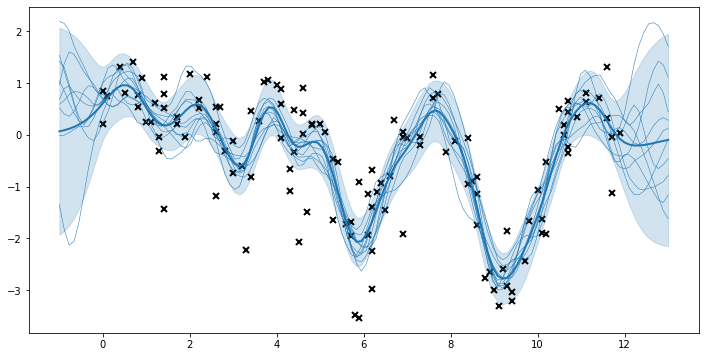

In [24]:
k = gpflow.kernels.Matern52(active_dims=[2])
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
gp_predict_fun(gp=m, xmin=-1, xmax=13, X=X, idx=2)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.5686871712696255   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.9229873107491471   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.kernels[1].W            │ Pa

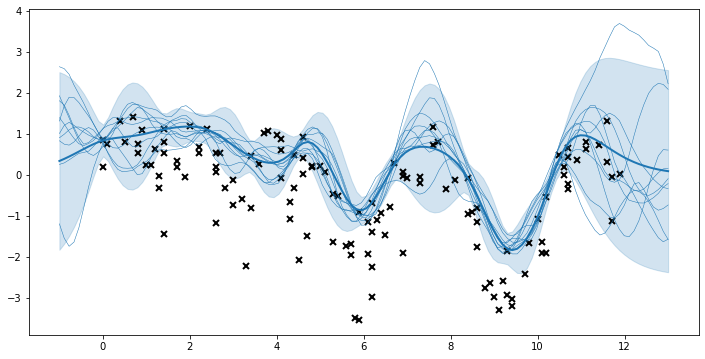

In [34]:
# k = gpflow.kernels.Matern52(active_dims=[2])
k = (gpflow.kernels.Matern52(active_dims=[2]) * 
    gpflow.kernels.Coregion(output_dim=len(np.unique(X[:,0])),
                            rank=1,active_dims=[0]))
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
set_trainable(m.kernel.kernels[1], False)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
gp_predict_fun(gp=m, xmin=-1, xmax=13, X=X, idx=2)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')